# Práctico 8 - Modelos de grafos

# Introducción

El objectivo de este práctico es explorar distintos modelos usados para generar
grafos de manera aleatoria.

A medida que vayamos presentando los distintos modelos, iremos explorando sus distintas propiedades. 

En el práctico 3, usted tuvo que analizar varios grafos desconocidos y analizar sus propiedades. Esos grafos fueron generados usando diferentes modelos que exploraremos en este práctico.

In [1]:
!pip install python-igraph > /dev/null
!pip install cairocffi > /dev/null
!pip install powerlaw > /dev/null

In [2]:
import igraph as ig
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

from collections import Counter
import powerlaw

In [3]:
random.seed(45)

#1) Erdös-Renyi

Recomendamos leer las Secciones 5.1 y 5.2 del libro [SANDR], antes de realizar esta sección. En lo que resta, nos basaremos en ellas.


Erdös-Renyi es uno de los modelos tradicionales en teoría de grafos (seguramente el modelo más difundido).

In [4]:
n = 100
p = 0.02

random.seed(42)
g_er = ig.Graph.Erdos_Renyi(n=n, p=p)

La cantidad de aristas es aleatoria, y en promedio es:  $\mathbb{E}[N_e]= {N_v \choose 2}p$.

In [5]:
from itertools import combinations
comb = len(list(combinations(range(n), 2)))
print('Valor esperado teórico de cantidad de aristas: ', int(comb*p))
 

In [6]:
g_er.ecount()

Los grafos generados usando un modelo Erdos Renyi no tienen que ser conexos.

In [7]:
g_er.is_connected()

Si $np > 1$, es muy probable que $G_{n,p}$ tenga una **componente conexa gigante** de tamaño $O(n)$.

Si $np < 1$, es muy probable que $G_{n,p}$ tenga componentes solo de tamaño $O(log n)$.


In [8]:
#esperamos que haya una componente gigante

n*p

In [9]:
components = [g_er.subgraph(x) for x in g_er.clusters()]

In [10]:
df_components = pd.DataFrame(components)
df_components["|V|"] = df_components[0].apply(lambda x: x.vcount())
df_components["|E|"] = df_components[0].apply(lambda x: x.ecount())
df_components.sort_values(by="|V|", ascending=False, inplace=True)

display(df_components)

Algunas propiedades tipicas de estos grafos son:

* Distribución de grado binomial con parámetros $(n − 1, p)$
* Bajo largo de camino promedio



In [11]:
sns.histplot(g_er.degree())

Grado promedio de la distribución

In [12]:
np.mean(g_er.degree())

Grado promedio de la distribución teórica

In [13]:
(n - 1) * p

Podemos observar que el camino promedio entre dos nodos es considerablemente
más corto que el diametro del grafo.

In [14]:
g_er.average_path_length()

In [15]:
g_er.diameter()

##1.1) Distribución de grado mientras $n$ crece y $p$ es constante

Supongamos que nos interesa estudiar que sucede con los grafos Erdös-Renyi al crecer la cantidad de vértices $n$.

Supongamos en esta sección que el parámetro $p$ es constante.

In [29]:
def compare_graph_historam_to_normal(n, p, seed):
  """
  Write a function that:
  
  1. Generates a random erdos renyi graph with parameters n, p and given seed.
  2. Plots the histogram distribution.
  3. Compares the histogram with a normal distribution with mean p*n
    and standard deviation (n * p * (1 - p))^(1/2)

  """
### START CODE HERE
### END CODE HERE


In [17]:
for n in [10, 100, 1000, 10000]:
  compare_graph_historam_to_normal(n, 0.02, 42)

Debe observarse que en estas condiciones la distribución de grado (que sabemos es una distribución binomial) tiende a una distribución Normal al crecer $n$, y mantenerse $p$ constante.

##1.2) Distribución de grado con $n$ constante a medida que $p$ crece

En la sección anterior manteníamos $p$ constante. Esto por lo general no tiene mucho sentido, porque implica que al crecer el grafo estaríamos disminuyendo el grado promedio notablemente (por tanto serían grafos de distinta naturaleza).

Si buscamos mantener el grado promedio (y la densidad de aristas), entonces debemos disminuir linealmente $p$ al crecer $n$.



In [18]:
def get_p_constant_average_degree(n: int, desired_degree: float) -> float:
  """
  Calculates the required parameter `p` such that the resulting
  Erdos Renyi model with parameters `n` and `p` has average
  degree `desired_degree`
  """
  return desired_degree / n

In [19]:
def compare_graph_historam_to_posion(n, deg, seed):
  """
  Write a function that:
  
  1. Generates a random erdos renyi graph with parameters n, average degree `deg` and seed.
  2. Plots the histogram distribution.
  3. Compares the histogram with a poisson distribution with mean D where
  D is the average degree of the distribution.

  """
### START CODE HERE
### END CODE HERE
  

In [20]:
for n in [50, 100, 1000, 5000, 10000]:
  compare_graph_historam_to_posion(n, 1.82, 42)

Debe observarse que en estas condiciones la distribución de grado (que sabemos es una distribución binomial) tiende a una distribución de Poisson al crecer $n$ y decrecer $p$.

#2) Modelo Barabási-Albert

Como vimos en el Teórico, existen modelos mucho más ricos que Erdös-Renyi (aunque matemáticamente menos trabajados).

Antes de realizar esta sección, leer las Secciones 5.3 y 5.4 del libro [SANDR]. En ellas se explican los modelos de configuración, acoplamiento preferencial, Barabási-Albert, y mundo pequeño.

A continuación trabajaremos con el modelo Barabási-Albert.

Una particularidad de este modelo es que la distribución de grado tiende a una **power-law con exponete 3** a medida que la cantidad de nodos tiende a infinito.

En el próximo fragmento vamos a estimar el coeficiente de la distribución de grado asumiendo que proviene de una distribución power-law y vamos a compararlo con el coeficiente teórico.

Primero grafiquemos la distribución empirica, la distribución power-law ajustada, y la distribución teórica (power-law de coeficiente 3).

In [21]:
for n in [10, 100, 1000, 10000, 100000, 1000000]:

    g_ba = ig.Graph.Barabasi(n, m=3)
    d = g_ba.degree()

    #ajusto power-law
    result = powerlaw.Fit(d)
    summary = f"N: {n} -- exponent: {result.alpha} -- x_min: {result.xmin}"

    #calculo empirical distribution
    xs = range(int(result.xmin), max(d))
    counter = Counter(d)
    dc = [counter.get(x, 0) / n for x in xs]

    fig, ax = plt.subplots()
    ax.scatter(xs, dc, label="Cumulative Distribution", marker='o', c='r')
    ax.plot(xs[1:], [x_ ** (-3 + 1) for x_ in xs[1:]], label="Theoretical distribution")
    ax.set_title(summary)
    ax.set_xlabel("degree")
    ax.set_ylabel("distribution")
    ax.set_xscale("log")
    ax.set_yscale("log")
    

Observamos que sucede lo visto en Teórico: los puntos se dispersan al aumentar el grado...

Por tanto pasemos a comparar la función de **distribución acumulada complementaria empírica (CCDF)** con las distribuciones teóricas y ajustada (power-law de parámetro $\alpha -1$).

In [22]:
for n in [10, 100, 1000, 10000, 100000, 1000000]:
#for n in [1000]:

    g_ba = ig.Graph.Barabasi(n, m=3)
    d = g_ba.degree()
    
    #ajusto power-law
    powerfit = powerlaw.Fit(d)
    summary = f"N: {n} -- exponent: {np.around(powerfit.alpha, decimals=3)} -- x_min: {int(powerfit.xmin)}"

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(d, bins=range(1, max(d)+1), density=True)
    # Now find the cdf
    cdf = np.cumsum(counts)
    ccdf = 1 - cdf

    fig, ax = plt.subplots()
    ax.scatter(bin_edges[1:], ccdf, marker='o', c='black', label="distribución acumulada complementaria (CCDF)")

    x = np.arange(powerfit.xmin, max(d))
    y_teo = np.power(x.astype('float'), (-3)+1)
    ax.plot(x, y_teo, c="blue", label="Theoretical distribution")

    y_fit = 1/(powerfit.alpha+1)* 1/powerfit.xmin * np.power(x/powerfit.xmin, -powerfit.alpha +1)
    ax.plot(x, y_fit, c="red", label="Fitted distribution")

    ax.set_title(summary)
    ax.set_xlabel("degree")
    ax.set_ylabel("CCDF")
    ax.set_xscale("log")
    ax.set_yscale("log")


#3) Distribución de grado de una red real

Mark Newman en 2006 creó un grafo de routers en Internet, con 22963 vértices (routers) y 48436 aristas (enlaces físicos entre routers).

In [23]:
!wget "https://github.com/prbocca/na101_master/blob/master/homework_08_models/internet_routers-22july06.gml.zip?raw=true" -O "internet_routers-22july06.gml.zip"

!unzip -o internet_routers-22july06.gml.zip

In [24]:
g_internet = ig.load("internet_routers-22july06.gml")

g_internet.summary()

## 3-1) (Opcional) Visualizar el grafo en Gephi. 

Visualizar los vértices de mayor grado con mayor tamaño, y los vértices con mayor PageRank más oscuros.

Debería obtenerse algo similar a la siguiente Figura.

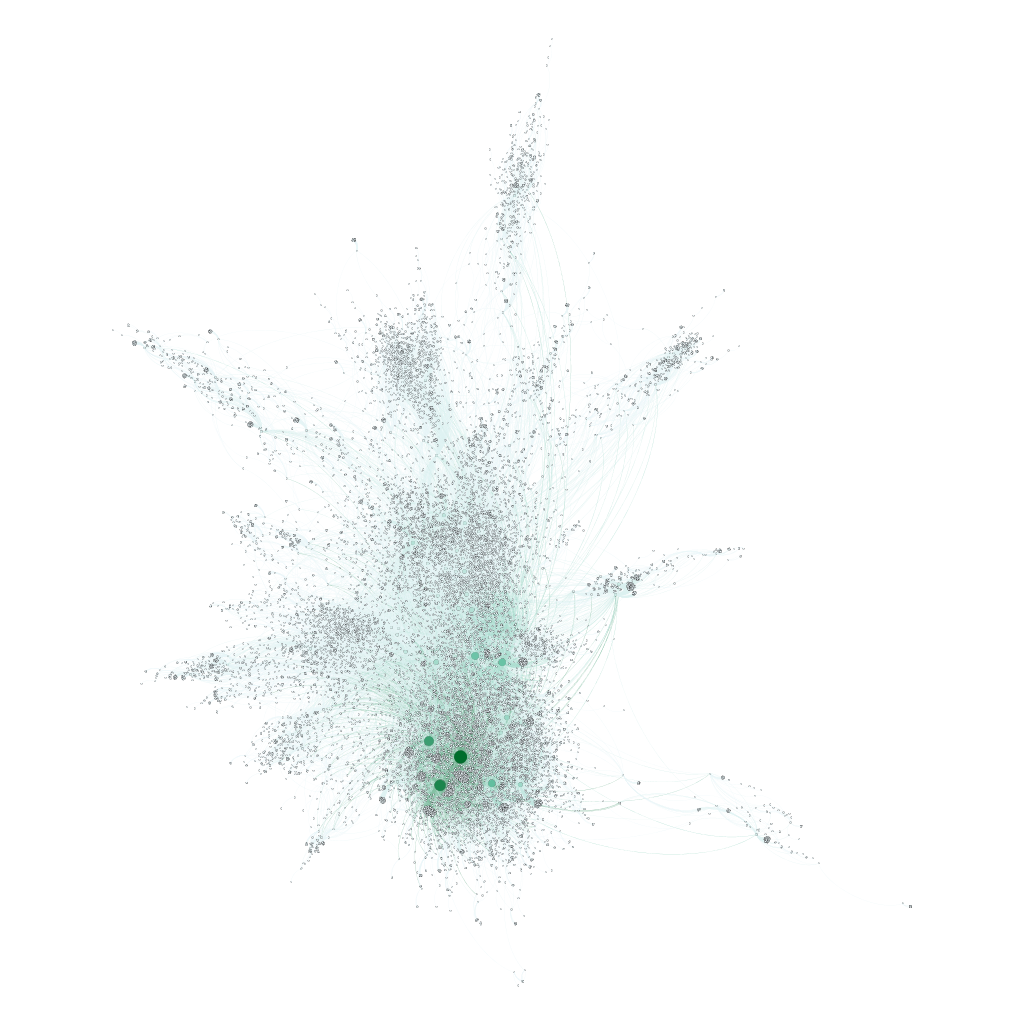

# 3.2) Graficar la distribución de grado.

Observar que si no se usa escala logarítmica en los ejes $x$ y $y$, no se puede visualizar correctamente, dada la altisima popularidad de grados bajos.

In [25]:
### START CODE HERE
### END CODE HERE


# 3.3) Graficar la función de distribución acumulada complementaria (CCDF).

Usar escala log-log.

In [28]:
### START CODE HERE
### END CODE HERE


# 3.4) Ajustar la distribución a una power-law. 

¿Cuál es el $\hat{\alpha}$ y el $x {min}$ del ajuste? 


Verificar el resultado comparando la CCDF
con la recta ajustada. 

La solución debería ser similar a la siguiente:

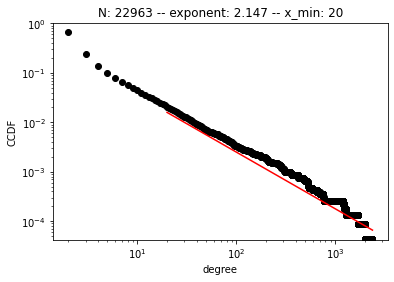



In [27]:
### START CODE HERE
### END CODE HERE
